# Spatial Analysis

### Imports

In [10]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from IPython.display import display, Markdown

### Define Paths

In [11]:
CWD = Path.cwd()
ROOT = CWD.parent if CWD.name.lower() == "notebooks" else CWD

DATA = ROOT / "data"
PROCESSED = DATA / "processed"
FIGURES = PROCESSED / "figures"

FIGURES.mkdir(parents=True, exist_ok=True)

print("Python:", sys.version.split()[0])
print("FIGURES:", FIGURES)

Python: 3.11.9
FIGURES: C:\Users\danci\Interconnection-Queue-Intelligence\data\processed\figures


### Load Processed Queue Data

In [12]:
public = pd.read_csv(PROCESSED / "public_queue_clean_combined.csv")
c15 = pd.read_csv(PROCESSED / "cluster15_clean_combined.csv")
c14 = pd.read_csv(PROCESSED / "cluster14_clean.csv")

display(pd.DataFrame({
    "dataset": ["public", "cluster15", "cluster14"],
    "rows": [len(public), len(c15), len(c14)],
}))

,dataset,rows
0,public,2290
1,cluster15,170
2,cluster14,363


### Filter to California

In [13]:
def filter_ca(df):
    if "state" in df.columns:
        return df[df["state"].str.upper().eq("CA")].copy()
    return df.copy()

public_ca = filter_ca(public)
c15_ca = filter_ca(c15)
c14_ca = filter_ca(c14)

display(pd.DataFrame({
    "dataset": ["public_ca", "cluster15_ca", "cluster14_ca"],
    "rows": [len(public_ca), len(c15_ca), len(c14_ca)],
}))

,dataset,rows
0,public_ca,2076
1,cluster15_ca,147
2,cluster14_ca,363


### Load California County Geometries

In [15]:
ca_counties = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_500k.zip"
)

ca_counties = ca_counties[ca_counties["STATEFP"] == "06"].copy()
ca_counties["county"] = ca_counties["NAME"].str.upper().str.strip()

ca_counties = ca_counties[["county", "geometry"]]

display(ca_counties.head())

,county,geometry
9,LOS ANGELES,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."
10,SONOMA,"POLYGON ((-123.53354 38.76841, -123.52851 38.7..."
11,ALAMEDA,"POLYGON ((-122.34225 37.80556, -122.33385 37.8..."
12,MENDOCINO,"POLYGON ((-124.02325 40.00128, -123.93545 40.0..."
13,DEL NORTE,"MULTIPOLYGON (((-124.2175 41.95081, -124.21704..."


### Aggregate MW by County

In [21]:
def norm_county(s):
    if pd.isna(s): 
        return ""
    return str(s).upper().strip()

def county_mw(df, label):
    df = df.copy()

    if "county" not in df.columns:
        out = pd.DataFrame({"county": [], "mw_sum": [], "label": []})
        return out

    df["county"] = df["county"].map(norm_county)

    # ensure mw_poi exists + numeric
    if "mw_poi" not in df.columns:
        df["mw_poi"] = np.nan
    df["mw_poi"] = pd.to_numeric(df["mw_poi"], errors="coerce")

    out = (
        df.groupby("county", dropna=False)["mw_poi"]
        .sum(min_count=1)
        .reset_index()
        .rename(columns={"mw_poi": "mw_sum"})
    )
    out["mw_sum"] = out["mw_sum"].fillna(0)
    out["label"] = label
    return out

# IMPORTANT: normalize county names in the geometry too
ca_counties = ca_counties.copy()
ca_counties["county"] = ca_counties["county"].map(norm_county)

pub_cnty = county_mw(public_ca[public_ca["sheet_outcome"]=="active"], "public_active")
c15_cnty = county_mw(c15_ca[c15_ca["sheet_outcome"]=="active"], "cluster15_active")
c14_cnty = county_mw(c14_ca, "cluster14_intake")

display(pd.DataFrame({
    "table": ["pub_cnty", "c15_cnty", "c14_cnty"],
    "rows": [len(pub_cnty), len(c15_cnty), len(c14_cnty)],
    "mw_sum_col_exists": ["mw_sum" in pub_cnty.columns, "mw_sum" in c15_cnty.columns, "mw_sum" in c14_cnty.columns]
}))
display(c14_cnty.head())

,table,rows,mw_sum_col_exists
0,pub_cnty,38,True
1,c15_cnty,29,True
2,c14_cnty,0,True


,county,mw_sum,label


## 1) Public Active MW by County (Choropleth)

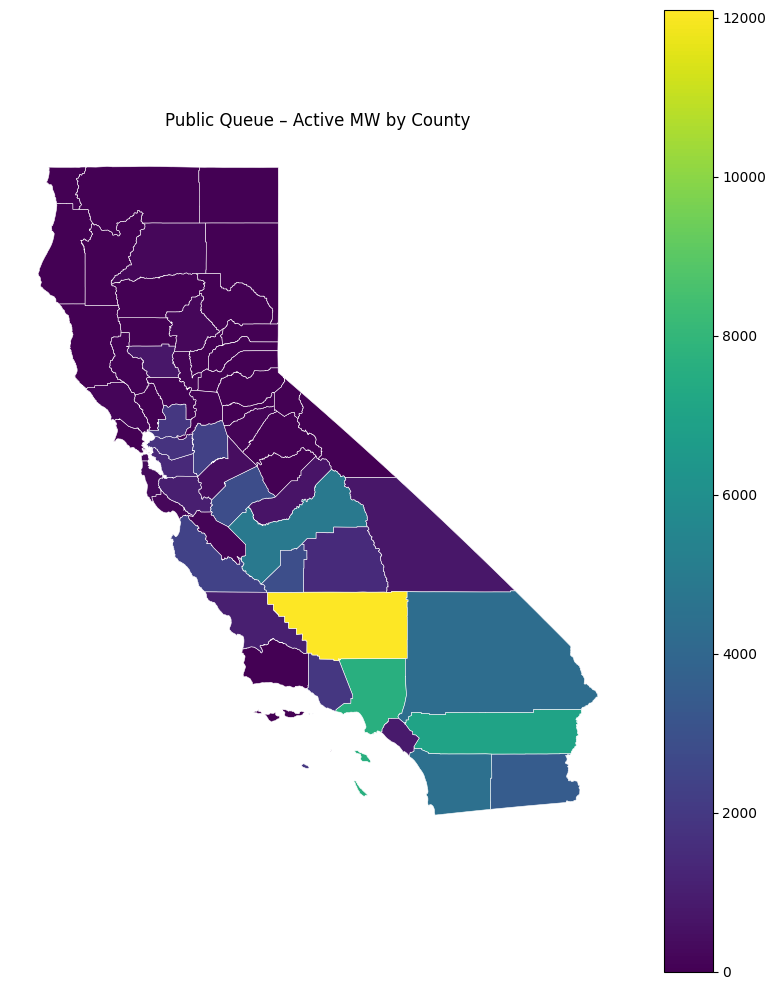

In [22]:
gdf_pub = ca_counties.merge(pub_cnty, on="county", how="left").fillna({"mw_sum": 0})

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
gdf_pub.plot(
    column="mw_sum",
    cmap="viridis",       # editable
    linewidth=0.4,
    ax=ax,
    edgecolor="white",
    legend=True
)

ax.set_title("Public Queue – Active MW by County")
ax.axis("off")

plt.tight_layout()
plt.savefig(FIGURES / "06a_public_active_mw_choropleth.png", dpi=200)
plt.show()

## 2) Intake MW by County (Cluster 14 vs Cluster 15)

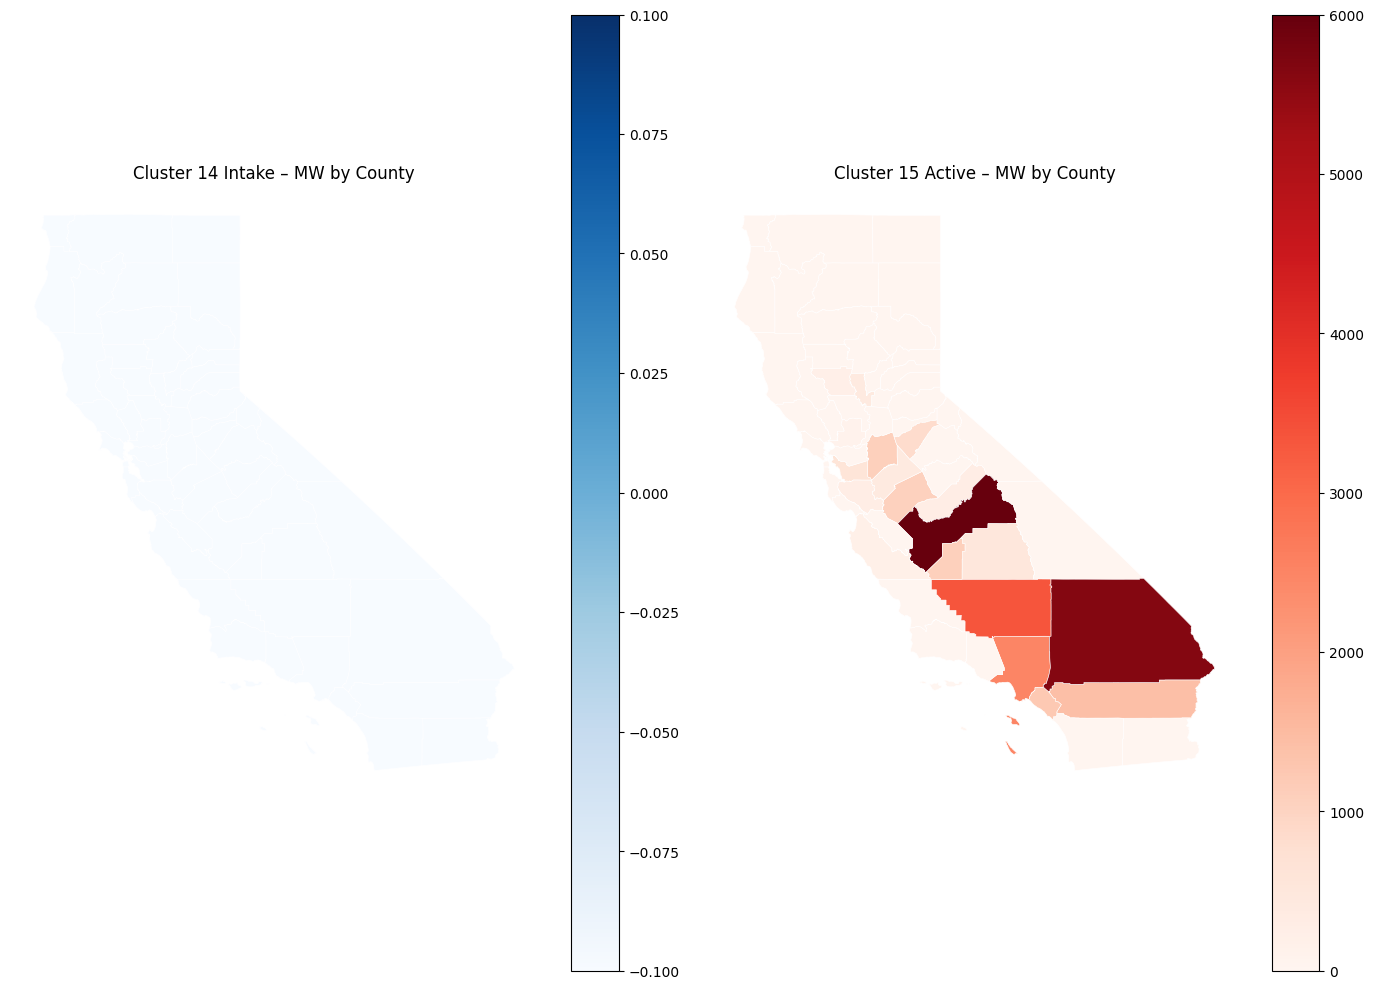

In [23]:
gdf_14 = ca_counties.merge(c14_cnty, on="county", how="left").fillna({"mw_sum": 0})
gdf_15 = ca_counties.merge(c15_cnty, on="county", how="left").fillna({"mw_sum": 0})

fig, axes = plt.subplots(1, 2, figsize=(14, 10))

gdf_14.plot(
    column="mw_sum",
    cmap="Blues",
    linewidth=0.4,
    ax=axes[0],
    edgecolor="white",
    legend=True
)
axes[0].set_title("Cluster 14 Intake – MW by County")
axes[0].axis("off")

gdf_15.plot(
    column="mw_sum",
    cmap="Reds",
    linewidth=0.4,
    ax=axes[1],
    edgecolor="white",
    legend=True
)
axes[1].set_title("Cluster 15 Active – MW by County")
axes[1].axis("off")

plt.tight_layout()
plt.savefig(FIGURES / "06b_cluster14_vs_15_choropleth.png", dpi=200)
plt.show()

## 3) MW Concentration (Bubble Map)

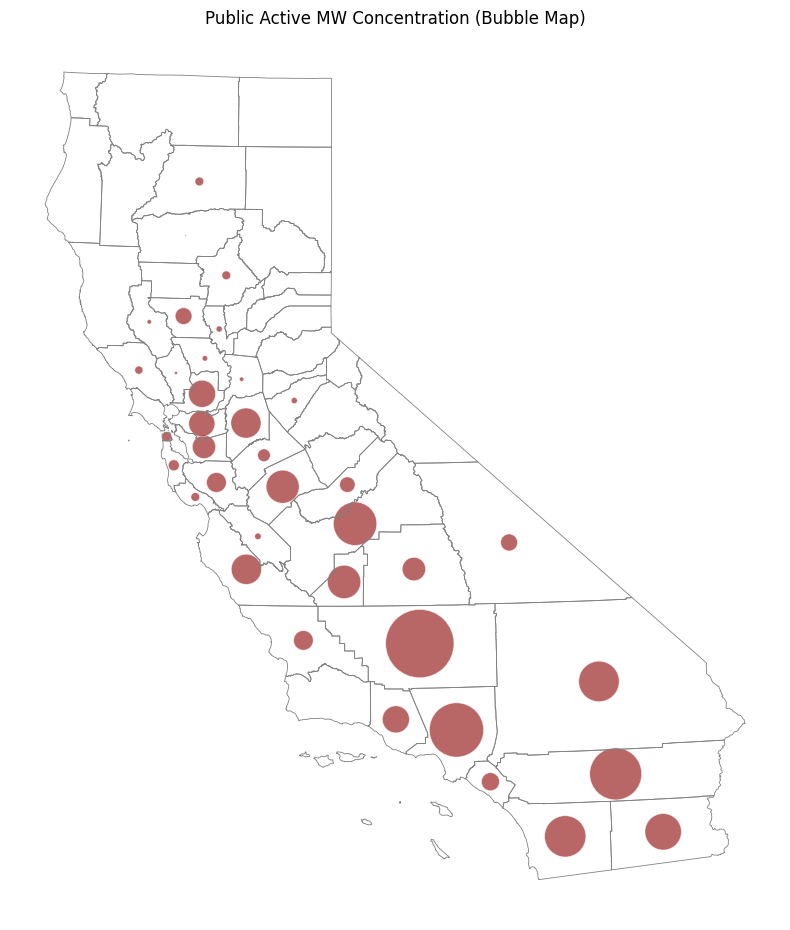

In [30]:
ca_proj = ca_counties.to_crs(epsg=3310).copy()

centroids = ca_proj.copy()
centroids["x"] = centroids.geometry.centroid.x
centroids["y"] = centroids.geometry.centroid.y

bubble = centroids.merge(pub_cnty, on="county", how="left").fillna({"mw_sum": 0})

fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# California outline (now in same CRS)
ca_proj.boundary.plot(ax=ax, linewidth=0.6, color="gray")

# Bubble overlay
ax.scatter(
    bubble["x"],
    bubble["y"],
    s=bubble["mw_sum"] / 5,   # size scaling (tune freely)
    alpha=0.6,
    color="darkred",
    edgecolor="white",
    linewidth=0.6,
)

ax.set_title("Public Active MW Concentration (Bubble Map)")
ax.axis("off")

plt.tight_layout()
plt.savefig(FIGURES / "06c_public_active_mw_bubbles.png", dpi=200)
plt.show()

## 4) Public Withdrawn vs Active MW by County

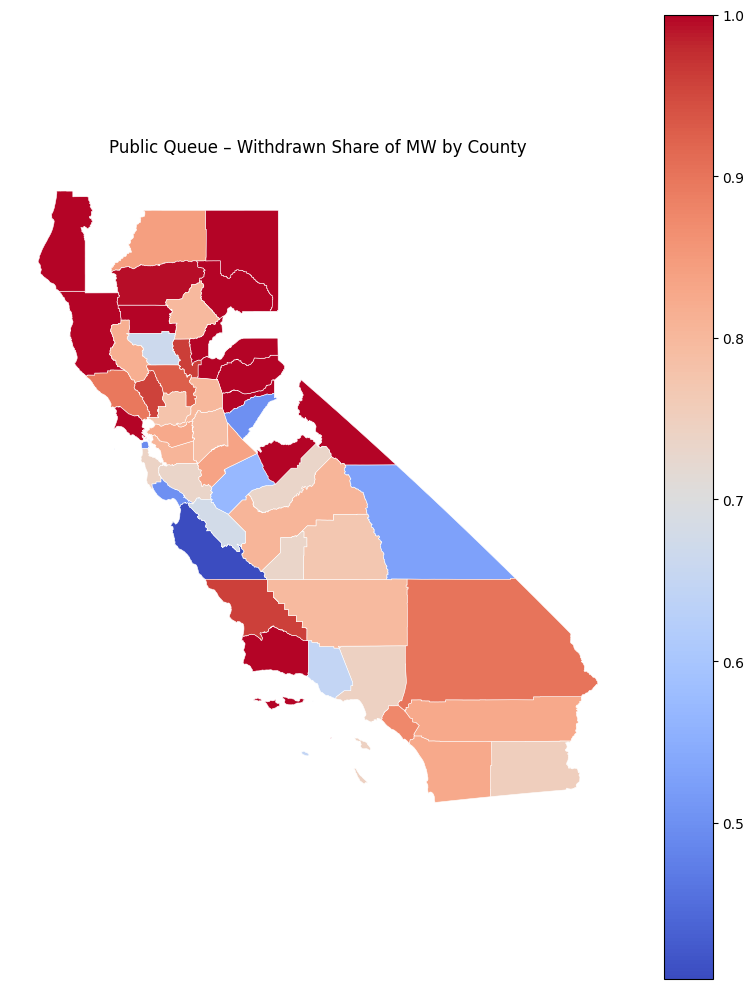

In [20]:
pub_w = county_mw(public_ca[public_ca["sheet_outcome"]=="withdrawn"], "withdrawn")
pub_a = county_mw(public_ca[public_ca["sheet_outcome"]=="active"], "active")

comp = pub_a.merge(pub_w, on="county", how="outer", suffixes=("_active","_withdrawn")).fillna(0)
comp["withdraw_share"] = comp["mw_sum_withdrawn"] / (
    comp["mw_sum_withdrawn"] + comp["mw_sum_active"]
).replace(0, np.nan)

gdf_comp = ca_counties.merge(comp, on="county", how="left")

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
gdf_comp.plot(
    column="withdraw_share",
    cmap="coolwarm",
    linewidth=0.4,
    ax=ax,
    edgecolor="white",
    legend=True
)

ax.set_title("Public Queue – Withdrawn Share of MW by County")
ax.axis("off")

plt.tight_layout()
plt.savefig(FIGURES / "06d_public_withdraw_share_choropleth.png", dpi=200)
plt.show()

### Key Takeaways
- County level is the **right spatial resolution** given current data
- Large MW concentrations cluster geographically (not uniformly)
- Intake clusters (14 vs 15) show **different spatial signatures**
- Withdrawn-heavy counties may indicate **grid constraints or permitting friction**